# Appliances Energy Forecasting

## Import Necessary Libraries

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
import pickle
from urllib.parse import quote
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose

## Import necessary API
import sys
sys.path.append('../../../../')
from api.v2.util.data_load import data_load
from api.v2.model.BILSTM import BiLSTM
from api.v2.util.compare_graph import compare_graph

## Import libraries for the model
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from sklearn.metrics import mean_squared_error, r2_score

## Set path for saving model training results 
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed
seed_val = 77
set_seed(seed_val)

cuda


## Base Parameter Setting
* Set parameters based on the information identified during EDA (Exploratory Data Analysis).

In [2]:
# Set Appliance Energy Data Base Parameter

# Set MachBase Neo URL address
URL = 'http://127.0.0.1:5654'
# Set Tag Table Name
table = 'appliance_energy'
# Set TimeFormat - > 'default' or '2006-01-02 15:04:05.000000'(Divided down to the nanosecond)
timeformat = 'Default'
# Set resample Option -> D(day), H(hour), T(minute), S(second)
resample_freq = None
# Set the desired tag names
tags = ['Appliances']
# Wrap each item in the list with single quotes and separate with commas
tags_ = ",".join(f"'{tag}'" for tag in tags)
# Set Tag Name
name = quote(tags_, safe=":/")
# Set Start time
start_time = '2016-01-11 17:00:00'
# Set End time 
end_time = '2016-05-27 18:00:00'
# Set TimeFormat - > 'default' or quote('2006-01-02 15:04:05.000000')(Divided down to the nanosecond)
timeformat = 'default'

## Appliance Energy Data Load

In [3]:
# Appliance Energy Data Load
df = data_load(URL, table, name, start_time, end_time, timeformat, resample_freq)

In [4]:
df

NAME,Appliances
TIME,
2016-01-11 17:00:00,60
2016-01-11 17:10:00,60
2016-01-11 17:20:00,50
2016-01-11 17:30:00,50
2016-01-11 17:40:00,60
...,...
2016-05-27 17:20:00,100
2016-05-27 17:30:00,90
2016-05-27 17:40:00,270


In [5]:
# Split the data into train, validation, and test sets
# The training data is set to data before May, and test data is set to May data

train = df[df.index.month < 5]
test = df[df.index.month == 5]

## Data Preprocessing
* 1 Set Decomposition & Lags
* 2 Min-Max Scaling

### 1. Set Decomposition & Lags

In [6]:
# Set Function
def decomp(df):
    # Time series decomposition
    decomposition = seasonal_decompose(df['Appliances'], model='additive', period=24)

    # Use only the trend
    trend = decomposition.trend 
    
    # Create a new DataFrame
    df = pd.DataFrame(trend.dropna().values, columns=['value'])
    df.index = trend.dropna().index
    
    # Create new columns with window applied
    df['lag4'] = df['value'].shift(4)  # Previous 40-min data
    df['lag3'] = df['value'].shift(3)  # Previous 30-min data
    df['lag2'] = df['value'].shift(2)  # Previous 20-min data 
    df['lag1'] = df['value'].shift(1)  # Previous 10-min data 
    
    # Remove missing values
    df = df.dropna()
    
    # Move 'value' column to the end
    df['value'] = df.pop('value')
    
    return df

In [7]:
# Apply decomp function
train = decomp(train)
test = decomp(test)

In [8]:
train

,lag4,lag3,lag2,lag1,value
TIME,,,,,
2016-01-11 19:40:00,133.541667,135.625000,137.708333,139.791667,141.666667
2016-01-11 19:50:00,135.625000,137.708333,139.791667,141.666667,143.541667
2016-01-11 20:00:00,137.708333,139.791667,141.666667,143.541667,145.625000
2016-01-11 20:10:00,139.791667,141.666667,143.541667,145.625000,153.750000
2016-01-11 20:20:00,141.666667,143.541667,145.625000,153.750000,167.916667
...,...,...,...,...,...
2016-04-30 21:10:00,68.750000,69.583333,69.166667,68.333333,67.083333
2016-04-30 21:20:00,69.583333,69.166667,68.333333,67.083333,65.416667
2016-04-30 21:30:00,69.166667,68.333333,67.083333,65.416667,64.375000


### 2. Min-Max Scaling

In [9]:
# Set up scalers
scaler_data = MinMaxScaler()
scaler_target = MinMaxScaler()

# Apply scalers
train_ = scaler_data.fit_transform(train.iloc[:, :-1].values)
train_t = scaler_target.fit_transform(train.iloc[:, -1:].values)

test_ = scaler_data.transform(test.iloc[:, :-1].values)
test_t = scaler_target.transform(test.iloc[:, -1:].values)

# Set each DataFrames
train_scaled = pd.DataFrame(train_)  
train_scaled['Appliances'] = train_t

test_scaled = pd.DataFrame(test_)
test_scaled['Appliances'] = test_t

# Save Scaler
with open('./result/scaler_data.pkl', 'wb') as file:
    pickle.dump(scaler_data, file)

with open('./result/scaler_target.pkl', 'wb') as file:
    pickle.dump(scaler_target, file)    

In [10]:
train_scaled

,0,1,2,3,Appliances
0,0.248826,0.254043,0.259259,0.264476,0.269171
1,0.254043,0.259259,0.264476,0.269171,0.273865
2,0.259259,0.264476,0.269171,0.273865,0.279082
3,0.264476,0.269171,0.273865,0.279082,0.299426
4,0.269171,0.273865,0.279082,0.299426,0.334898
...,...,...,...,...,...
15849,0.086594,0.088680,0.087637,0.085550,0.082420
15850,0.088680,0.087637,0.085550,0.082420,0.078247
15851,0.087637,0.085550,0.082420,0.078247,0.075639
15852,0.085550,0.082420,0.078247,0.075639,0.073552


## Dataset & Loader Setup

### Window Dataset Configuration
* To train on time series data, you need to set the window size and the sliding step.

* Window size: Determines how many time points to group together.
* Step size: The time interval by which the window moves.

In [11]:
# Sliding Window Dataset Configuration
class SlidingWindowDataset(Dataset):
    def __init__(self, data, window_size, step_size):
        self.data = data
        self.window_size = window_size
        self.step_size = step_size
        self.windows, self.targets = self._create_windows()
    
    # Set up sliding windows
    def _create_windows(self):
        windows = []
        targets = []
        for i in range(0, len(self.data) - self.window_size + 1, self.step_size):
            window = self.data.iloc[i:i + self.window_size, :-1].values  # Exclude the last column
            target_array = self.data.iloc[i:i + self.window_size, -1].values  # The last column is the target
                
            windows.append(torch.Tensor(window))
            targets.append(torch.Tensor(target_array))  # Convert target to Tensor
        return windows, targets
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return self.windows[idx], self.targets[idx]

In [12]:
# Sliding window configuration
window_size = 6
step_size = 1

# Set up datasets 
train_ = SlidingWindowDataset(train_scaled, window_size, step_size)
test_ = SlidingWindowDataset(test_scaled, window_size, step_size)

# Set up data loaders
train_dataloader = DataLoader(train_, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_, batch_size=64, shuffle=False)

In [13]:
# Verify DataLoader application and check the shape of the input data
print(list(train_dataloader)[0][0].shape)

torch.Size([64, 6, 4])


## Model Configuration
* Using BILSTM model.

In [14]:
# Model configuration parameters

# number of input data columns
# last number in print(list(train_dataloader)[0][0].shape)
input_dim = 4

# BILSTM hidden state size
hidden_dim = 64

# layer size
num_layers = 2

# Learning rate
learning_rate = 0.01

# Model configuration
model = BiLSTM(input_dim, hidden_dim, num_layers, window_size, dropout=0.2).to(device)

# Configure loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Check the model architecture
print(model)

BiLSTM(
  (bilstm): LSTM(4, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


## Model Training

* Save the model with the Best Loss based on the validation data during training.

In [15]:
# Initialize loss
train_loss = []
# Initialize total step
total_step = len(train_dataloader)
# Set number of epochs
epoch_in = trange(100, desc='training')
# Initialize best Loss value
best_Loss= np.inf

# Start model training
for epoch in epoch_in:
    model.to(device)
    model.train()
    running_loss = 0.0

    for batch_idx, train_data in enumerate(train_dataloader):

        inputs = train_data[0].to(device).float()
        target = train_data[1].to(device).float()

        optimizer.zero_grad()
        
        # Input to the model
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs.squeeze(), target)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss)}')

    # Save the best model
    if best_Loss > np.mean(train_loss):
        best_Loss = np.mean(train_loss)
        torch.save(model, f'./result/Appliance_Energy_Full.pt')
        print('Model saved')
    epoch_in.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")

training:   0%|          | 0/100 [00:00<?, ?it/s]


train loss: 0.006535349056306468
Model saved

train loss: 0.004516506753354348
Model saved

train loss: 0.00324676151446892
Model saved

train loss: 0.0025203540452447405
Model saved

train loss: 0.0021097889569861557
Model saved

train loss: 0.0018428223049807857
Model saved

train loss: 0.0016585677381128485
Model saved

train loss: 0.0015185089669836498
Model saved

train loss: 0.0013672449058397898
Model saved

train loss: 0.0012544902321634812
Model saved

train loss: 0.0011603372814744644
Model saved

train loss: 0.001147995028315651
Model saved

train loss: 0.0011016062029046419
Model saved

train loss: 0.0010316319797910032
Model saved

train loss: 0.0009731003057055126
Model saved

train loss: 0.0009324801191770721
Model saved

train loss: 0.0008903459171259467
Model saved

train loss: 0.0008513389222655218
Model saved

train loss: 0.000820653790097669
Model saved

train loss: 0.0008127246270972927
Model saved

train loss: 0.0007804264194900666
Model saved

train loss: 0.0007

## Model Testing

In [16]:
model_ = torch.load(f'./result/Appliance_Energy_Full.pt')

In [17]:
# Initial settings 
output_test = []
target_test = []

with torch.no_grad():
    model_.eval()
    running_loss_t = 0.0
    
    for batch_idx, test_data in enumerate(test_dataloader):
        
        inputs_t = test_data[0].to(device).float()
        target_t = test_data[1].to(device).float()

        outputs_t = model_(inputs_t)
        
        output_test.append(outputs_t)
        target_test.append(target_t)
        
# Combine tensors into one
combined_tensor_target = torch.cat(target_test, dim=0)
combined_tensor_pred = torch.cat(output_test, dim=0)

# Use only the last value of the window
last_values_target = combined_tensor_target[:, -1].cpu()
last_values_pred = combined_tensor_pred[:, -1].cpu()

# Inverse transform using MinMaxScaler 
real_values = scaler_target.inverse_transform(last_values_target.numpy().reshape(-1, 1))
real_pred_values = scaler_target.inverse_transform(last_values_pred.numpy().reshape(-1, 1))

## Model Performance Evaluation

In [18]:
# Calculate MSE
mse = mean_squared_error(real_values, real_pred_values)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(real_values, real_pred_values)
print("R² Score:", r2)

Mean Squared Error: 3.6727126
R² Score: 0.9987332809630746


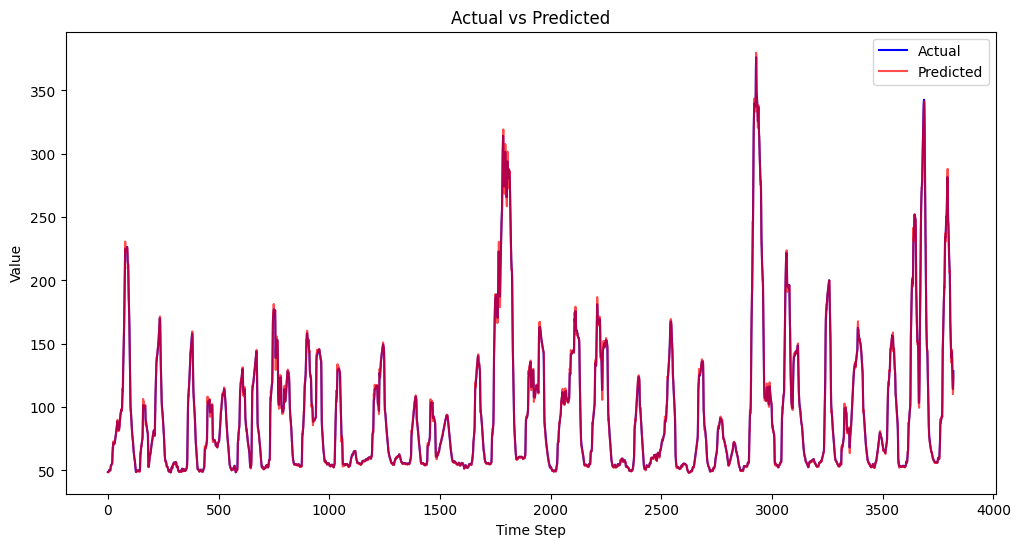

In [19]:
# Compare the test results: Actual values vs Predicted values

# Plot width
x_size=12
# Plot height
y_size=6
# Print Compare_graph
compare_graph(real_values, real_pred_values, x_size, y_size)